In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=60360b8c3a6c0bc8d4bb75e089db12520b9a3c4c3b19c0953cb59d56554dbdd1
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


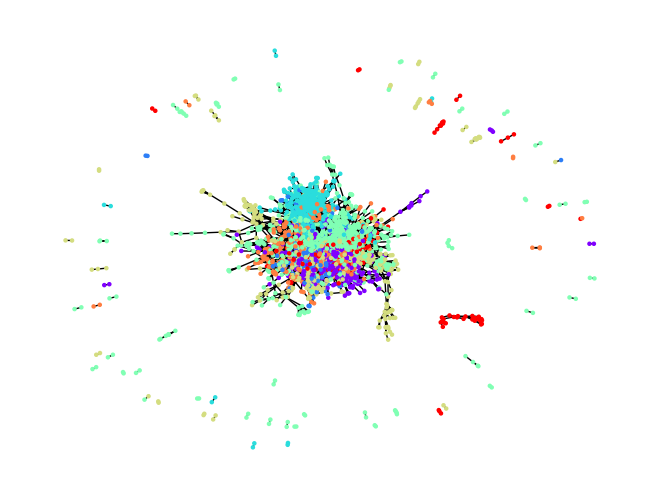

Epoch 001: loss 1.9547
Epoch 026: loss 0.0002
Epoch 051: loss 0.0000
Epoch 076: loss 0.0000
Epoch 101: loss 0.0000
Epoch 126: loss 0.0000
Epoch 151: loss 0.0000
Epoch 176: loss 0.0000
Test accuracy: 0.7790


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

import networkx as nx
import matplotlib.pyplot as plt

# Define GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_feats, h_feats)
        self.conv2 = GCNConv(h_feats, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load and prepare datasets
def load_dataset(dataset_name):
    dataset = Planetoid(root='./data', name=dataset_name)
    return dataset[0]


# Visualize the dataset using NetworkX
def visualize_dataset(data):
    edge_index = data.edge_index.t().numpy()
    G = nx.Graph()
    G.add_nodes_from(range(data.num_nodes))
    G.add_edges_from(edge_index)
    pos = nx.spring_layout(G, seed=42)
    node_colors = [data.y[i].item() for i in range(data.num_nodes)]
    nx.draw(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=5, with_labels=False)
    plt.show()

if __name__ == "__main__":
    dataset_name = "Cora"  # Change to "Citeseer" if you want to use the Citeseer dataset, DBLP
    data = load_dataset(dataset_name)
    features = data.x
    edge_index = data.edge_index
    num_classes = int(data.y.max()) + 1
    num_features = features.shape[1]

    # Convert features and labels to PyTorch tensors
    features = features.float()
    labels = data.y

    # Visualize the dataset
    visualize_dataset(data)


    # Define model and training parameters
    model = GCN(num_features, 128, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        logits = model(features, edge_index)
        loss = criterion(logits[data.train_mask], labels[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch%25 == 0:
          print(f"Epoch {epoch+1:03d}: loss {loss.item():.4f}")

    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        logits = model(features, edge_index)
        pred = logits.argmax(dim=1)
        test_mask = data.test_mask
        accuracy = (pred[test_mask] == labels[test_mask]).float().mean()
        print(f"Test accuracy: {accuracy.item():.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SAGEConv

# Define GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load and prepare datasets
def load_dataset(dataset_name):
    dataset = Planetoid(root='./data', name=dataset_name)
    return dataset[0]

if __name__ == "__main__":
    dataset_name = "Cora"  # Change to "Citeseer" if you want to use the Citeseer dataset
    data = load_dataset(dataset_name)
    features = data.x
    edge_index = data.edge_index
    num_classes = int(data.y.max()) + 1
    num_features = features.shape[1]

    # Convert features and labels to PyTorch tensors
    features = features.float()
    labels = data.y

    # Define model and training parameters
    model = GraphSAGE(num_features, 128, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        logits = model(features, edge_index)
        loss = criterion(logits[data.train_mask], labels[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch%25 == 0:
          print(f"Epoch {epoch+1:03d}: loss {loss.item():.4f}")


    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        logits = model(features, edge_index)
        pred = logits.argmax(dim=1)
        test_mask = data.test_mask
        accuracy = (pred[test_mask] == labels[test_mask]).float().mean()
        print(f"Test accuracy: {accuracy.item():.4f}")


Epoch 001: loss 1.9481
Epoch 026: loss 0.0000
Epoch 051: loss 0.0000
Epoch 076: loss 0.0000
Epoch 101: loss 0.0000
Epoch 126: loss 0.0000
Epoch 151: loss 0.0000
Epoch 176: loss 0.0000
Test accuracy: 0.7590


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GINConv, global_add_pool

# Define GIN model
class GIN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GIN, self).__init__()
        self.conv1 = GINConv(nn.Sequential(
            nn.Linear(in_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, h_feats)
        ))
        self.conv2 = GINConv(nn.Sequential(
            nn.Linear(h_feats, h_feats),
            nn.ReLU(),
            nn.Linear(h_feats, num_classes)
        ))

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Load and prepare datasets
def load_dataset(dataset_name):
    dataset = Planetoid(root='./data', name=dataset_name)
    return dataset[0]

if __name__ == "__main__":
    dataset_name = "Cora"  # Change to "Citeseer" if you want to use the Citeseer dataset
    data = load_dataset(dataset_name)
    features = data.x
    edge_index = data.edge_index
    num_classes = int(data.y.max()) + 1
    num_features = features.shape[1]

    # Convert features and labels to PyTorch tensors
    features = features.float()
    labels = data.y

    # Define model and training parameters
    model = GIN(num_features, 128, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        logits = model(features, edge_index)
        loss = criterion(logits[data.train_mask], labels[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch%25 == 0:
          print(f"Epoch {epoch+1:03d}: loss {loss.item():.4f}")


    # Evaluate on the test set
    model.eval()
    with torch.no_grad():
        logits = model(features, edge_index)
        pred = logits.argmax(dim=1)
        test_mask = data.test_mask
        accuracy = (pred[test_mask] == labels[test_mask]).float().mean()
        print(f"Test accuracy: {accuracy.item():.4f}")


Epoch 001: loss 1.9630
Epoch 002: loss 2.7379
Epoch 003: loss 3.5859
Epoch 004: loss 2.0045
Epoch 005: loss 1.6889
Epoch 006: loss 1.3742
Epoch 007: loss 1.1400
Epoch 008: loss 0.9436
Epoch 009: loss 0.7531
Epoch 010: loss 0.5690
Epoch 011: loss 0.4125
Epoch 012: loss 0.2902
Epoch 013: loss 0.2343
Epoch 014: loss 0.1496
Epoch 015: loss 0.1006
Epoch 016: loss 0.0629
Epoch 017: loss 0.0295
Epoch 018: loss 0.0141
Epoch 019: loss 0.0072
Epoch 020: loss 0.0042
Epoch 021: loss 0.0024
Epoch 022: loss 0.0019
Epoch 023: loss 0.0006
Epoch 024: loss 0.0003
Epoch 025: loss 0.0005
Epoch 026: loss 0.0001
Epoch 027: loss 0.0000
Epoch 028: loss 0.0000
Epoch 029: loss 0.0000
Epoch 030: loss 0.0000
Epoch 031: loss 0.0000
Epoch 032: loss 0.0000
Epoch 033: loss 0.0000
Epoch 034: loss 0.0003
Epoch 035: loss 0.0000
Epoch 036: loss 0.0000
Epoch 037: loss 0.0000
Epoch 038: loss 0.0000
Epoch 039: loss 0.0000
Epoch 040: loss 0.0000
Epoch 041: loss 0.0000
Epoch 042: loss 0.0000
Epoch 043: loss 0.0000
Epoch 044: 